# Overview
This notebook documents the initial preprocessing of the dataset and training of a logistical regression model to establish a baseline for our analysis. Excluding the target, there are a total of 13 features. Most of them are categorical and missing values to varying degrees.

In [138]:
# Import dependencies.
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt


In [139]:
# Read in the data.
df = pd.read_csv('hr_job_change.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18014 entries, 0 to 18013
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             18014 non-null  int64  
 1   city                    18014 non-null  object 
 2   city_development_index  18014 non-null  float64
 3   gender                  18014 non-null  object 
 4   relevent_experience     18014 non-null  object 
 5   enrolled_university     18014 non-null  object 
 6   education_level         18014 non-null  object 
 7   major_discipline        18014 non-null  object 
 8   experience              18014 non-null  object 
 9   company_size            18014 non-null  object 
 10  company_type            18014 non-null  object 
 11  last_new_job            18014 non-null  object 
 12  training_hours          18014 non-null  int64  
 13  target                  18014 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [140]:
# Summarize the features with missing values.
df.isnull().sum()[df.isnull().sum() != 0]

Series([], dtype: int64)

# Features
Data transformation, including filling in missing values, for each feature is looked at individually.

## 0. `enrollee_id`
`enrollee_id` is used to identify those enrolled in the program. Since it is unique for each record and has no bearing on the target, it can be dropped.

In [141]:
df.enrollee_id.nunique()

18014

In [142]:
df.drop(columns='enrollee_id', inplace=True)

## 1. `city`
`city` with low counts can be binned together to reduce the total number of categories.

In [143]:
df.city.value_counts(dropna=False).head(20)

city
city_103    4194
city_21     2454
city_16     1471
city_114    1254
city_160     817
city_136     542
city_67      414
city_75      295
city_102     287
city_104     287
city_73      270
city_100     259
city_71      256
city_11      231
city_61      191
city_28      183
city_90      178
city_23      173
city_65      165
city_36      154
Name: count, dtype: int64

In [144]:
# Create a bin for cities with fewer than `threshold` instances.
threshold = 200
city_counts = df['city'].value_counts()
cities_to_replace = city_counts[city_counts<threshold].index

for city in cities_to_replace:
    df['city'] = df['city'].replace(city, 'Other')

df['city'].value_counts(dropna=False)

city
Other       4983
city_103    4194
city_21     2454
city_16     1471
city_114    1254
city_160     817
city_136     542
city_67      414
city_75      295
city_102     287
city_104     287
city_73      270
city_100     259
city_71      256
city_11      231
Name: count, dtype: int64

## 2. `city_development_index`
This is one of the two numerical features in the dataset, and it is already scaled. If the `city` values are kept, it can be confirmed that each city has a single `city_development_index`, but different cities might share the same value: `all(df.groupby('city')['city_development_index'].nunique() == 1)` returns `True`.

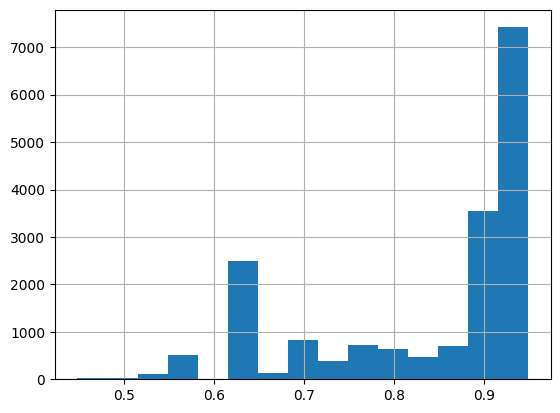

In [145]:
# Create a histogram for `city_development_index`.
df['city_development_index'].hist(bins=15);

## 3. `gender`
Missing values need to be dealt with. It's not immediately clear how to go about it: do we impute with the most frequent value to simply group it with `Other`? Since there are 10 males to 1 female in this training problem, we can approach this problem with filling in the missing values with the most frequent value of the feature, i.e., `Male`. The same approach is used for the other categorical features unless otherwise stated.

In [146]:
df['gender'].value_counts(dropna=False)

gender
Male      16633
Female     1208
Other       173
Name: count, dtype: int64

In [147]:
df['gender'].fillna('Male', inplace=True)
df['gender'].value_counts(dropna=False)

gender
Male      16633
Female     1208
Other       173
Name: count, dtype: int64

## 4. `relevent_experience`
This is one of the few categorical features without missing values. Since it refers to the individual having or not having relevant experience, and it can be converted to `1`'s and `0`'s.

In [148]:
df['relevent_experience'].value_counts(dropna=False)

relevent_experience
Has relevent experience    13190
No relevent experience      4824
Name: count, dtype: int64

In [149]:
df['relevent_experience'].replace('Has relevent experience', 1, inplace=True)
df['relevent_experience'].replace('No relevent experience', 0, inplace=True)
df['relevent_experience'].value_counts(dropna=False)

relevent_experience
1    13190
0     4824
Name: count, dtype: int64

## 5. `enrolled_university`
Missing values are imputed with the most frequent value.

In [150]:
df['enrolled_university'].value_counts(dropna=False)

enrolled_university
no_enrollment       13348
Full time course     3517
Part time course     1149
Name: count, dtype: int64

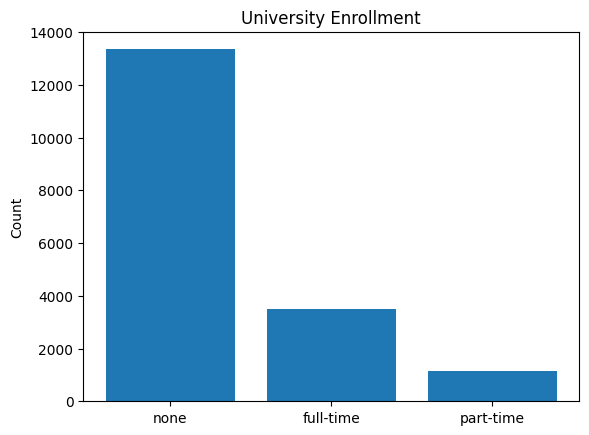

In [200]:
df['enrolled_university'].fillna('no_enrollment', inplace=True)
df['enrolled_university'].replace('no_enrollment', 'none', inplace=True)
df['enrolled_university'].replace('Full time course', 'full-time', inplace=True)
df['enrolled_university'].replace('Part time course', 'part-time', inplace=True)

value_counts = df['enrolled_university'].value_counts(dropna=False)

# Creating a bar graph
plt.bar(value_counts.index, value_counts.values)
plt.ylabel('Count')
plt.title('University Enrollment')
plt.show()

## 6. `education_level`
Missing values are imputed with the most frequent value.

In [152]:
df['education_level'].value_counts(dropna=False)

education_level
Graduate          11188
Masters            4228
High School        1908
Phd                 399
Primary School      291
Name: count, dtype: int64

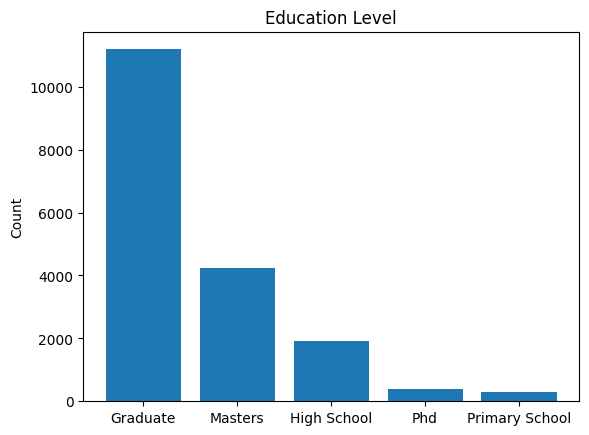

In [194]:
df['education_level'].fillna('Graduate', inplace=True)
df['education_level'].value_counts(dropna=False)

value_counts = df['education_level'].value_counts(dropna=False)

# Creating a bar graph
plt.bar(value_counts.index, value_counts.values)
plt.ylabel('Count')
plt.title('Education Level')
plt.show()


## 7. `major_discipline`
Missing values are imputed with the most frequent value. STEM stands for science, technology, engineering and mathematics.

In [154]:
df['major_discipline'].value_counts(dropna=False)

major_discipline
STEM               16213
Humanities           655
Other                364
Business Degree      322
Arts                 248
No Major             212
Name: count, dtype: int64

In [155]:
df['major_discipline'].fillna('STEM', inplace=True)
df['major_discipline'].value_counts(dropna=False)

major_discipline
STEM               16213
Humanities           655
Other                364
Business Degree      322
Arts                 248
No Major             212
Name: count, dtype: int64

## 8. `experience`
Missing values for candidate's total experience in years are imputed with the most frequent value.

In [156]:
df['experience'].value_counts(dropna=False)

experience
>20    3182
5      1337
4      1298
3      1223
6      1143
2       997
7       982
10      946
9       936
8       768
15      668
11      649
14      569
16      488
1       475
12      475
<1      451
13      387
17      331
19      294
18      273
20      142
Name: count, dtype: int64

In [157]:
df['experience'].fillna('>20', inplace=True)
df['experience'].value_counts(dropna=False)

experience
>20    3182
5      1337
4      1298
3      1223
6      1143
2       997
7       982
10      946
9       936
8       768
15      668
11      649
14      569
16      488
1       475
12      475
<1      451
13      387
17      331
19      294
18      273
20      142
Name: count, dtype: int64

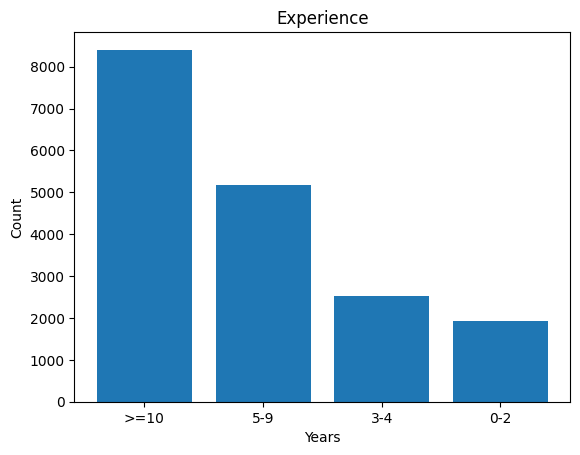

In [196]:
# Create bins for boarder categorization of experience.
for exp in ['<1', '1', '2']:
    df['experience'].replace(exp, '0-2', inplace=True)
for exp in ['3', '4']:
    df['experience'].replace(exp, '3-4', inplace=True)
for exp in ['5', '6', '7', '8', '9']:
    df['experience'].replace(exp, '5-9', inplace=True)
for exp in ['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '>20']:
    df['experience'].replace(exp, '>=10', inplace=True)

value_counts = df['experience'].value_counts(dropna=False)

# Creating a bar graph
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Years')
plt.ylabel('Count')
plt.title('Experience')
plt.show()

## 9. `company_size`
Missing values for the company size are imputed with the most frequent value.

In [159]:
df['company_size'].value_counts(dropna=False)

company_size
<10          6552
50-99        2950
100-500      2483
10000+       1964
10/49        1394
1000-4999    1282
500-999       847
5000-9999     542
Name: count, dtype: int64

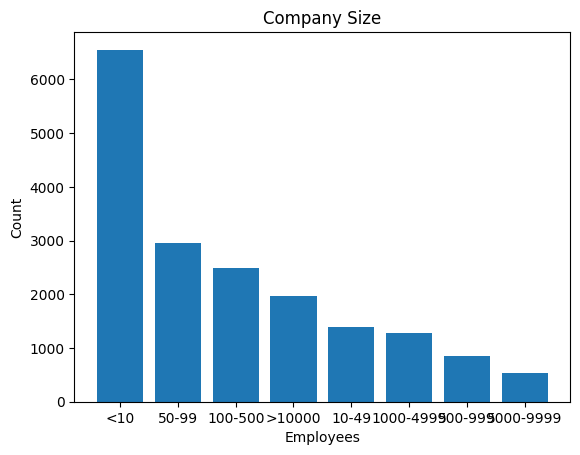

In [199]:
df['company_size'].replace('10/49', '10-49', inplace=True)
df['company_size'].replace('10000+', '>10000', inplace=True)
df['company_size'].fillna('50-99', inplace=True)
df['company_size'].value_counts(dropna=False)

value_counts = df['company_size'].value_counts(dropna=False)

# Creating a bar graph
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Employees')
plt.ylabel('Count')
plt.title('Company Size')
plt.show()

## 10. `company_type`
Missing values for the company type are imputed with the most frequent value.

In [161]:
df['company_type'].value_counts(dropna=False)

company_type
Pvt Ltd                14402
Public Sector           1456
Funded Startup           977
Early Stage Startup      565
NGO                      500
Other                    114
Name: count, dtype: int64

In [162]:
df['company_type'].fillna('Pvt Ltd', inplace=True)
df['company_type'].value_counts(dropna=False)

company_type
Pvt Ltd                14402
Public Sector           1456
Funded Startup           977
Early Stage Startup      565
NGO                      500
Other                    114
Name: count, dtype: int64

## 11. `last_new_job`
Missing values for difference in years between previous and current job are imputed with the most frequent value.

In [163]:
df['last_new_job'].value_counts(dropna=False)

last_new_job
1        7789
>4       3210
2        2827
never    2187
4        1010
3         991
Name: count, dtype: int64

In [164]:
df['last_new_job'].fillna('1', inplace=True)
df['last_new_job'].value_counts(dropna=False)

last_new_job
1        7789
>4       3210
2        2827
never    2187
4        1010
3         991
Name: count, dtype: int64

## 12. `training_hours`

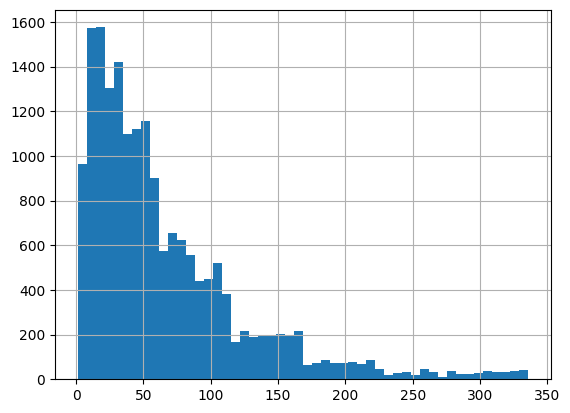

In [165]:
df['training_hours'].hist(bins=50);

## 13. `target`
`target` is imbalanced, so it needs to be addressed by ensuring `stratify=y` and/or resampling.

In [166]:
df['target'].value_counts(dropna=False)

target
0.0    13593
1.0     4421
Name: count, dtype: int64

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18014 entries, 0 to 18013
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    18014 non-null  object 
 1   city_development_index  18014 non-null  float64
 2   gender                  18014 non-null  object 
 3   relevent_experience     18014 non-null  int64  
 4   enrolled_university     18014 non-null  object 
 5   education_level         18014 non-null  object 
 6   major_discipline        18014 non-null  object 
 7   experience              18014 non-null  object 
 8   company_size            18014 non-null  object 
 9   company_type            18014 non-null  object 
 10  last_new_job            18014 non-null  object 
 11  training_hours          18014 non-null  int64  
 12  target                  18014 non-null  float64
dtypes: float64(2), int64(2), object(9)
memory usage: 1.8+ MB


# Model Implementation

In [168]:
model_df = pd.get_dummies(df)
model_df.head()

,city_development_index,relevent_experience,training_hours,target,city_Other,city_city_100,city_city_102,city_city_103,city_city_104,city_city_11,...,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,0.920,1,36,1.0,False,False,False,True,False,False,...,False,False,False,True,True,False,False,False,False,False
1,0.776,0,47,0.0,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,0.624,0,83,0.0,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
3,0.767,1,8,0.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,0.764,1,24,1.0,True,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False


In [169]:
# Split the data into a training set and a testing set.
y = model_df.target
X = model_df.drop(columns='target')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Instantiate a StandardScaler instance.
scaler = StandardScaler()

# Fit the training data to the standard scaler.
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler.
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler.
X_test_scaled = X_scaler.transform(X_test)

In [170]:
# Due to imbalanced target values, instantiate the random oversampler model.
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_scaled, y_train)

In [171]:
# Implement a logistic regression model.
classifier = LogisticRegression(solver='lbfgs', random_state=42)
classifier.fit(X_res, y_res)
predictions = classifier.predict(X_test_scaled)

In [172]:
# Display the accuracy score for the test dataset.
print(f'Accuracy score: {accuracy_score(y_test, predictions):.2f}')

Accuracy score: 0.76


In [173]:
# Display the confusion matrix.
confusion_matrix(y_test, predictions)

array([[2590,  809],
       [ 276,  829]], dtype=int64)

| n=19158 | Predicted: Staying | Predicted: Leaving |
| --- | --- | --- |
| Actual: Staying | 2678 | 918 |
| Actual: Leaving | 313 | 881 |


In [174]:
# Display the classification report.
target_names = ['stay', 'leave']
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

        stay       0.90      0.76      0.83      3399
       leave       0.51      0.75      0.60      1105

    accuracy                           0.76      4504
   macro avg       0.70      0.76      0.72      4504
weighted avg       0.81      0.76      0.77      4504



Considering that a recall score of 0.74 is achieved for predicting individuals leaving their current employment, this is a good starting point for our analysis.

# Feature Importance

In [175]:
importance = classifier.coef_[0]

In [176]:
for i,v in enumerate(importance):
    if abs(v)>=0.1:
        print(f'Feature: {X.columns[i]}, Score: {v:.3f}')

Feature: city_development_index, Score: -0.597
Feature: relevent_experience, Score: -0.163
Feature: city_Other, Score: -0.173
Feature: city_city_103, Score: 0.165
Feature: city_city_136, Score: -0.129
Feature: city_city_16, Score: -0.110
Feature: city_city_21, Score: 0.285
Feature: city_city_67, Score: -0.102
Feature: education_level_Graduate, Score: 0.102
Feature: education_level_High School, Score: -0.163
Feature: education_level_Primary School, Score: -0.134
Feature: company_size_100-500, Score: -0.175
Feature: company_size_1000-4999, Score: -0.107
Feature: company_size_50-99, Score: -0.125
Feature: company_size_500-999, Score: -0.106
Feature: company_size_<10, Score: 0.415
Feature: company_size_>10000, Score: -0.107
Feature: last_new_job_never, Score: -0.156


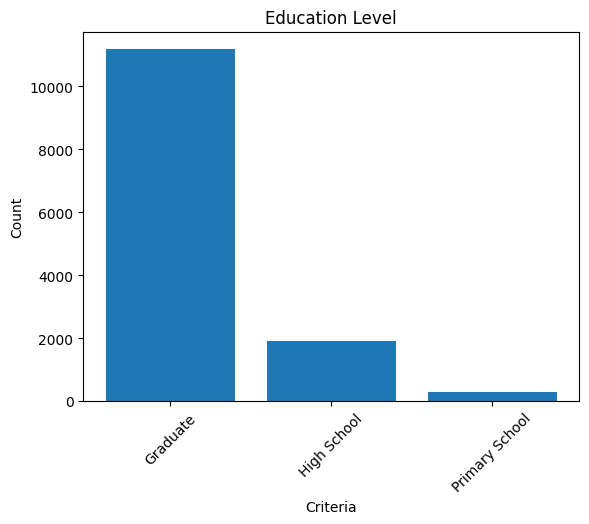

In [177]:
# Criteria 1
criteria_1 = ['education_level_Graduate', 'education_level_High School', 'education_level_Primary School']

# Mapping of original column names
label_mapping_1 = {
    'education_level_Graduate': 'Graduate',
    'education_level_High School': 'High School',
    'education_level_Primary School': 'Primary School'
}

true_counts_1 = []  # Store the counts of True values for Criteria 1
x_labels_1 = []  # Store the corresponding column labels for Criteria 1

for criterion in criteria_1:
    if criterion in X.columns:
        true_count = X.loc[X[criterion] == True, criterion].value_counts().loc[True]
        true_counts_1.append(true_count)
        x_labels_1.append(label_mapping_1.get(criterion, criterion))

# Plotting the bar chart
plt.bar(x_labels_1, true_counts_1)
plt.xlabel('Criteria')
plt.ylabel('Count')
plt.title('Education Level')
plt.xticks(rotation=45)

plt.show()

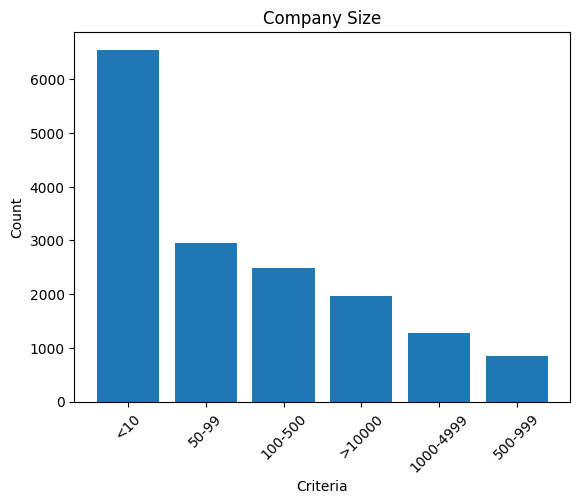

In [178]:
# Criteria 2
criteria_2 = ['company_size_100-500', 'company_size_1000-4999', 'company_size_50-99',
              'company_size_500-999', 'company_size_<10', 'company_size_>10000']

# Mapping of original column names
label_mapping_2 = {
    'company_size_100-500': '100-500',
    'company_size_1000-4999': '1000-4999',
    'company_size_50-99': '50-99',
    'company_size_500-999': '500-999',
    'company_size_<10': '<10',
    'company_size_>10000': '>10000'
}

true_counts_2 = []  # Store the counts of True values for Criteria 2
x_labels_2 = []  # Store the corresponding column labels for Criteria 2

for criterion in criteria_2:
    if criterion in X.columns:
        true_count = X.loc[X[criterion] == True, criterion].value_counts().loc[True]
        true_counts_2.append(true_count)
        x_labels_2.append(label_mapping_2.get(criterion, criterion))

# Sort the data in descending order
sorted_data = sorted(zip(true_counts_2, x_labels_2), reverse=True)
true_counts_2, x_labels_2 = zip(*sorted_data)

# Plotting the bar chart
plt.bar(x_labels_2, true_counts_2)
plt.xlabel('Criteria')
plt.ylabel('Count')
plt.title('Company Size')
plt.xticks(rotation=45)

plt.show()

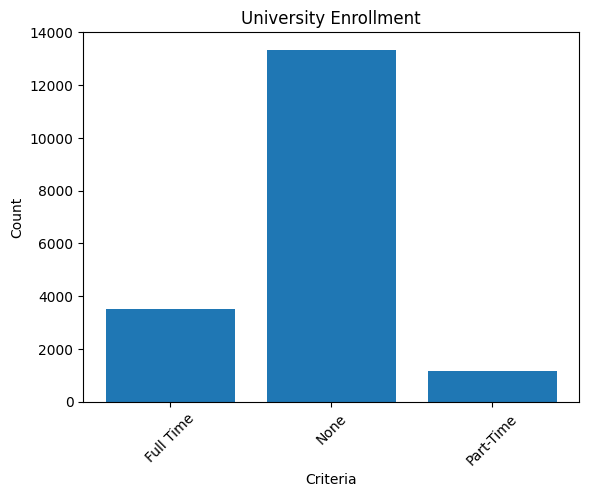

In [179]:
import matplotlib.pyplot as plt

# Criteria 1
criteria_1 = ['enrolled_university_full-time', 'enrolled_university_none', 'enrolled_university_part-time']

# Mapping of original column names
label_mapping = {
    'enrolled_university_full-time': 'Full Time',
    'enrolled_university_none': 'None',
    'enrolled_university_part-time': 'Part-Time'
}

true_counts = []  # Store the counts of True values
x_labels = []  # Store the corresponding column labels

for criterion in criteria_1:
    if criterion in X.columns:
        true_count = X.loc[X[criterion] == True, criterion].value_counts().loc[True]
        true_counts.append(true_count)
        x_labels.append(label_mapping.get(criterion, criterion))

# Plotting the bar chart
plt.bar(x_labels, true_counts)
plt.xlabel('Criteria')
plt.ylabel('Count')
plt.title('University Enrollment')
plt.xticks(rotation=45)

plt.show()

In [180]:
df[df['city']=='city_103']['city_development_index'].unique()[0]

0.92

In [181]:
df[df['city']=='city_114']['city_development_index'].unique()[0]

0.926

In [182]:
df[df['city']=='city_136']['city_development_index'].unique()[0]

0.897

In [183]:
df[df['city']=='city_21']['city_development_index'].unique()[0]

0.624

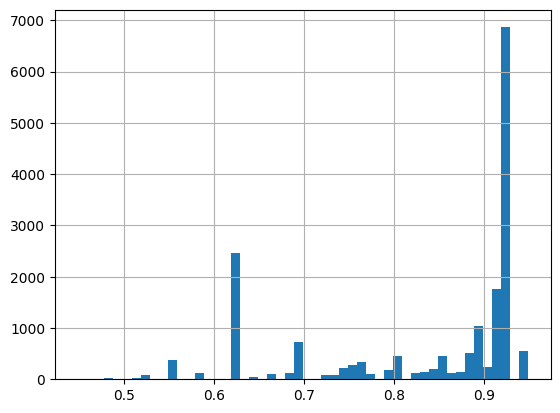

In [184]:
df['city_development_index'].hist(bins=50);

In [185]:
df['city_development_index'].describe()

count    18014.000000
mean         0.831728
std          0.122115
min          0.448000
25%          0.745000
50%          0.910000
75%          0.920000
max          0.949000
Name: city_development_index, dtype: float64

In [186]:
df[['city_development_index', 'target']].corr()

,city_development_index,target
city_development_index,1.000000,-0.336234
target,-0.336234,1.000000


In [187]:
# from sklearn.ensemble import RandomForestClassifier

# # Create the random forest classifier instance
# rf_model = RandomForestClassifier(n_estimators=500, random_state=42)
# rf_model = rf_model.fit(X_res, y_res)
# predictions = rf_model.predict(X_test_scaled)

# # Display the accuracy score for the test dataset.
# print(f'Accuracy score: {accuracy_score(y_test, predictions):.2f}')

# # Display the confusion matrix.
# confusion_matrix(y_test, predictions)

# # Display the classification report.
# target_names = ['stay', 'leave']
# print(classification_report(y_test, predictions, target_names=target_names))